# WATER BAG CLASSIFICATION - IMBALANCE AND CALIBRATION
### BASED ON INMET METHEOROLOGICAL STATIONS DATA

---
#### Import modules and libraries

In [1]:
import os, json, pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns; sns.set()
from IPython.display import clear_output as co

## Load & Preprocess Data

#### Water bag groupped events collection

In [2]:
waterbags = pd.read_csv('../Dados/Catalog/water_bag_catalog_google.csv', index_col=0)
clusters = pd.read_csv('../Dados/Catalog/water_bag_clusters.csv', index_col=0)

events = waterbags[['EVENTO_INICIO', 'EVENTO_FIM']].apply(pd.to_datetime)
events = events.join(clusters[['sublabel', 'main_route']], how='inner')

display(events.head(4)); display(events.shape)

,EVENTO_INICIO,EVENTO_FIM,sublabel,main_route
EVENTO_ID,,,,
1258,2015-09-12 20:12:00,2015-09-13 03:39:00,12,Praia de Botafogo
1259,2015-09-12 22:13:00,2015-09-13 01:21:00,-1,Avenida Brasil
1260,2015-09-12 22:15:00,2015-09-13 01:20:00,-1,Avenida Brasil
1261,2015-09-12 22:16:00,2015-09-13 01:20:00,-1,Avenida Brasil


(2983, 4)

#### INMET metheorlogical stations' records

In [3]:
inmet = pd.read_csv('../Dados/Clean/INMET.csv', index_col=0)

inmet.set_index(pd.to_datetime(inmet.index), inplace=True); inmet.shape

(108864, 65)

#### Event labeled time serie

In [4]:
event_ts = pd.read_csv('../Dados/Transform/waterbag_timeserie_inmet.csv', index_col=0)

event_ts['event groups'] = event_ts['event groups'].map(json.loads)
event_ts['event ids'] = event_ts['event ids'].map(json.loads)
event_ts.set_index(pd.to_datetime(event_ts.index), inplace=True)

display(event_ts.head(), event_ts.shape)

,label,events,event ids,event groups
2010-01-01 00:00:00,0,0,[],[]
2010-01-01 01:00:00,0,0,[],[]
2010-01-01 02:00:00,0,0,[],[]
2010-01-01 03:00:00,0,0,[],[]
2010-01-01 04:00:00,0,0,[],[]


(108863, 4)

#### Event labeled time serie per group

In [5]:
group_ts = pd.read_csv('../Dados/Transform/waterbag_clusters_timeserie_inmet.csv', index_col=0)
group_ts.set_index(pd.to_datetime(group_ts.index), inplace=True)

display(group_ts.sample(5), group_ts.shape)

,-1,0,1,2,3,4,5,6,7,8,...,54,56,57,58,59,60,61,63,65,67
2010-01-09 02:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2010-04-10 23:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-07-28 02:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-06-05 02:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-05-05 02:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(108863, 62)

---
## Define Functions


#### Time series feature dataset transformation pipeline

In [6]:
from Modulos.timeserie_transform import TimeseriesTransformPipeline
from Modulos.imbalanced_selection import groupConsecutiveFlags, MinorityGroupSplitUndersample
# from Modulos.imbalanced_classification import ClassificationPipeline

#### Binary classification pipeline functions

In [7]:
from sklearn.ensemble import GradientBoostingClassifier as gbc
class ClassificationPipeline:
    
    def __init__(self,
        train_size=0.79, train_prct=1,
        test_size=0.2, test_prct=None,
        n_splits=1, shuffle=True,
        random_state=None,
    ):
        self.train_size=train_size; self.test_size=test_size;
        self.train_prct=train_prct; self.test_prct=test_prct;
        self.n_splits=n_splits; self.shuffle=shuffle;
        self.random_state=random_state

    # Binary classification pipeline function
    def binary(
        self, X, Y, model=gbc(),
        groups=None, strategy=None,
        return_cls_cnt=False, store=True,
    ):
        if strategy is not None:
            splitter = MinorityGroupSplitUndersample(
                n_splits=self.n_splits,
                train_size=self.train_size, train_prct=self.train_prct,
                test_size=self.test_size, test_prct=self.test_prct,
                random_state=self.random_state, 
            )
            cv = list(splitter.split(
                X, Y, groups, strategy=strategy
            )); t_ind, e_ind = cv[0][0], cv[0][1]
            xt, xe, yt, ye = X.iloc[t_ind], X.iloc[e_ind], Y.iloc[t_ind], Y.iloc[e_ind]
        else:
            guss = GroupUnderSampleSplit(  # Splitter Instance
                train_size=self.train_size, train_prct=self.train_prct,
                test_size=self.test_size, test_prct=self.test_prct,
            )
            xt, xe, yt, ye = guss.undersample(  # Train and test x and y dataframes
                X, Y, shuffle=self.shuffle, random_state=self.random_state
            )
        cls_cnt = print_cls_cnt(
            Y, yt.index, ye.index,
            display_cnt=(not return_cls_cnt),
            return_cnt=return_cls_cnt
        )
        model.fit(xt, yt)  # Fit model with train data
        yhat = model.predict(xe)  # Make predictions
        scrs = pd.DataFrame(cr(ye, yhat, output_dict=True)).T  # Evaluate model prediction
        if store:
            self.split = (yt.index, ye.index)
            self.model = model
        if return_cls_cnt:
            return scrs, cls_cnt
        return scrs

    # Multiple targets binary classification pipeline function - Changing Traget variable
    def binary_multi_target(
        self,
        X, Yi, model=gbc(),
        groups=None, strategy=None,
    ):
        scrs, cls_cnts = {}, {}
        for i, label in enumerate(Yi):
            co(wait=True); print(f'{i+1}/{Yi.shape[1]} models evaluated.')
            scrs[label], cls_cnts[label] = self.binary(
                X, Yi[label], model=model,
                groups=groups[label], strategy=strategy,
                return_cls_cnt=True, store=False
            )
        scrs, cls_cnts = pd.concat(scrs), pd.concat(cls_cnts)
        scrs.index.names = ['group', 'metric']
        cls_cnts.index.names = ['Group', 'Class']
        return scrs, cls_cnts

def classesGroupRecall(scrs, cls_cnts, ignore_first=5):

    fig, ax = plt.subplots(1, 3, figsize=(20, 3.5))

    scrs['recall'].loc[:, ['0', '1', 'macro avg']].unstack('metric').sort_values('1').plot(use_index=False, ax=ax[0])
    ax[0].set(
        title='Groups Recall per Class - Minority class sorted',
        xlabel='Group',
        ylabel='Recall'
    )

    sort_scrs = scrs['recall'].loc[:, ['0', '1', 'macro avg']].unstack('metric').sort_values('macro avg')
    sort_scrs.plot(use_index=False, ax=ax[1])
    ax[1].set(
        title='Groups Recall per Class - Macro avg sorted',
        xlabel='Group',
        ylabel='Recall'
    )

    train_size, test_size = (mms().fit_transform(cls_cnts[col].loc[sort_scrs.index[ignore_first:], 1].to_frame(col)).reshape(-1).tolist() for col in ['Train set', 'Test set'])
    train_size = [np.nan]*ignore_first + train_size 
    test_size = [np.nan]*ignore_first + test_size 

    ax[2].plot(train_size)
    ax[2].plot(test_size)

    return ax

---
### Preprocessing & machine learning modules

In [8]:
from sklearn.preprocessing import MinMaxScaler as mms
from Modulos.cv_samplers import GroupUnderSampleSplit, print_cls_cnt

from sklearn.utils import all_estimators
from sklearn.metrics import classification_report as cr

from imblearn import ensemble
from imblearn.metrics import classification_report_imbalanced as cri

#  Classifier colleciton
classifiers = dict(all_estimators('classifier'))

# Select specific classification models
gbc = classifiers['GradientBoostingClassifier']
brfc = ensemble.BalancedRandomForestClassifier

c:\Users\luisr\anaconda3\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


### Select example water bag group

In [9]:
routes = clusters.groupby(['sublabel', 'main_route']).first().index.to_frame().set_index('sublabel').to_dict()['main_route']

top_grps_cnt = events['sublabel'].value_counts()
top_grps_hour = group_ts.sum().sort_values(ascending=False)

# top_grp = top_grps_cnt.index[0]
top_grp = top_grps_hour.index[4]
# top_grp = '1'

### Define feature dataset and target variables

#### Metheorological data after first registered waterbag event

In [10]:
print(f'Train and test sets for water bag group: {routes[int(top_grp)]}. (id: {top_grp})')
Y = group_ts[str(top_grp)].copy()
group_min_time = Y[Y==1].index.min() # Group specific minimum value

X = TimeseriesTransformPipeline(
    inmet, group_min_time, cut=-1,
    drop_empty_cols=True, scale=True,
    interpolate=None, fillna=None
)

Xf = TimeseriesTransformPipeline(
    X, interpolate='nearest', fillna='min'
)


Y = Y.loc[X.index]
display(Y.value_counts().to_frame('Class Count'))

Train and test sets for water bag group: Rua do Catete. (id: 1)
Initial data: (108864, 65)
Time extraction: (55925, 65)
Drop empty columns:  (55924, 52)
Initial data: (55924, 52)


,Class Count
0,55628
1,296


### Instatiate classification pipeline object

In [11]:
CP = ClassificationPipeline(
    n_splits=5,
    train_size=0.79, train_prct=1,
    test_size=0.2, test_prct=None,
    shuffle=True, random_state=2,
)

### Fit base line model

In [12]:
groups = groupConsecutiveFlags(ts=Y)

# Model & Evaluate
score, cls_cnt = CP.binary(
    Xf, Y,
    gbc(n_estimators=100, random_state=0),
    groups=groups, strategy='GroupShuffleSplit',
    return_cls_cnt=True, store=True
)

display(score, cls_cnt)

,precision,recall,f1-score,support
0,0.999860,0.901453,0.948110,55395.000000
1,0.009975,0.887097,0.019727,62.000000
accuracy,0.901437,0.901437,0.901437,0.901437
macro avg,0.504917,0.894275,0.483919,55457.000000
weighted avg,0.998753,0.901437,0.947072,55457.000000


,Train set,Test set
Class,,
0,233,55395
1,233,62


### Groups Analysis

#### Hour groups count

In [13]:
len(groups.unique())

87

#### Consecutive hour groups hours count

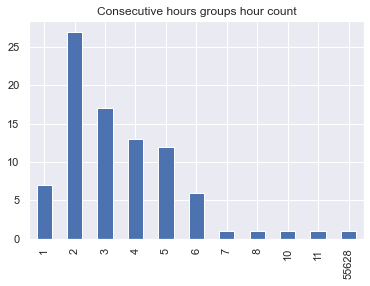

In [14]:
ax = groups.value_counts().value_counts().sort_index().plot.bar(title='Consecutive hours groups hour count')

---
# Filter hour records by variables threshold

In [15]:
def multi_min_msk(data, desc, stat='min', acumulate=None, top_down=True):

    filter_stats = []
    for col in data:
        min_value = desc.loc[stat, col]
        if stat=='min':
            above_min = data[col].fillna(min_value) >= min_value
        elif stat=='max':
            above_min = data[col].fillna(min_value) <= min_value
        filter_stats.append([col, min_value, above_min.sum(), above_min.sum()/len(data)*100])
    filter_stats = pd.DataFrame(filter_stats, columns=['column', 'threshold', 'rows left', 'rows left (%)'])
    filter_stats = filter_stats.sort_values('rows left', ascending=top_down).reset_index(drop=True)

    if acumulate is not None:
        cum_stats = []
        for col in filter_stats['column']:
            min_value = desc.loc[stat, col]
            if stat=='min':
                above_min = data[col].fillna(min_value) >= min_value
            elif stat=='max':
                above_min = data[col].fillna(min_value) <= min_value
            if col == filter_stats['column'].iloc[0]:
                above_min_cum = above_min
            else:
                if acumulate=='or':
                    above_min_cum = above_min_cum | above_min
                elif acumulate=='and':
                    above_min_cum = above_min_cum & above_min
            cum_stats.append([col, min_value, above_min_cum.sum(), above_min_cum.sum()/len(data)*100])
        cum_stats = pd.DataFrame(cum_stats, columns=['column', 'threshold', 'rows left cum', 'rows left cum (%)'])
        return filter_stats, cum_stats
    
    return filter_stats

### Records left after filtering by columns' minimum thresholds

In [16]:
#### Extract minority and majority classes records
mino, majo = X[Y==1], X[~(Y==1)]
mino_desc = mino.describe()

#### Filter records by minority minimum values
stats, cum_stats = multi_min_msk(X, mino_desc, stat='min', acumulate='and', top_down=True)
stats_max, cum_stats_max = multi_min_msk(X, mino_desc, stat='max', acumulate='and', top_down=True)

### Plot result

#### Records above and below target minimum and maximum per column

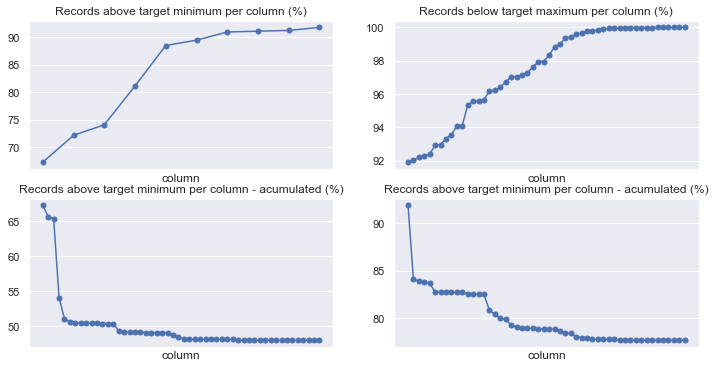

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(12, 6))

stats.set_index('column')['rows left (%)'].head(10).plot(marker='o', ms=5, xticks=[], title='Records above target minimum per column (%)', ax=ax[0][0])
stats_max.set_index('column')['rows left (%)'].head(100).plot(marker='o', ms=5, xticks=[], title='Records below target maximum per column (%)', ax=ax[0][1])

cum_stats.set_index('column')['rows left cum (%)'].plot(xticks=[], marker='o', ms=5, title='Records above target minimum per column - acumulated (%)', ax=ax[1][0])
cum_stats_max.set_index('column')['rows left cum (%)'].plot(xticks=[], marker='o', ms=5, title='Records above target minimum per column - acumulated (%)', ax=ax[1][1])
plt.show()

---
# Evaluate Filtered Records

In [18]:
def filter_by_min(X, min_values=None, max_values=None, n_filters=10, margin_min=0.0, margin_max=0.0):
    X_filt = X.copy()
    if min_values is not None:
        index = min_values.index[:n_filters]
    else:
        index = max_values.index[:n_filters]
    for col in index:
        if min_values is not None:
            min_value =  min_values[col] * (1 + margin_min)
            X_filt = X_filt[X_filt[col].fillna(min_value) >= min_value]
        if max_values is not None:
            max_value =  max_values[col] * (1 - margin_max)
            X_filt = X_filt[X_filt[col].fillna(max_value) <= max_value]
    print('\nRecords:', X.shape[0]); print('Records left:', X_filt.shape[0])
    print('Records left (%):', round(X_filt.shape[0] / X.shape[0] * 100, 1), '%\n')
    return X_filt

### Filter records

In [44]:
min_values = mino_desc.loc['min'].loc[stats['column']]
max_values = mino_desc.loc['max'].loc[stats['column']]
X_filt = filter_by_min(
    X, min_values, max_values,
    n_filters=len(stats),
    margin_min=0.0, margin_max=0.0
)

### Transform filtered data
X_filt = Xf.loc[X_filt.index]
# X_filt = TimeseriesTransformPipeline(
#     X_filt, interpolate='nearest', fillna='min'
# )

### Filter target variable
Y_filt = Y.loc[X_filt.index]

display(Y_filt.value_counts().to_frame('Class Count'))
display(Y_filt.value_counts().to_frame('Class Count') / Y.value_counts().to_frame('Class Count'))


Records: 55924
Records left: 21219
Records left (%): 37.9 %



,Class Count
0,20923
1,296


,Class Count
0,0.376124
1,1.000000


### Evaluate left base model test set

In [45]:
groups_filt = groupConsecutiveFlags(ts=Y_filt)

t_ind, e_ind = CP.split
xt, xe, yt, ye = Xf.loc[t_ind], Xf.loc[e_ind], Y.loc[t_ind], Y.loc[e_ind]
XE = xe.loc[set(xe.index).intersection(X_filt.index)]
YE = ye.loc[XE.index] # ; YT = yt.loc[XT.index]

Yhat = CP.model.predict(XE)

display(YE.value_counts().to_frame('Class Count - Base split test left'))
# display(YT.value_counts().to_frame('Class Count - Base split train left'))
pd.DataFrame(cr(YE, Yhat, output_dict=True)).T

,Class Count - Base split test left
0,20828
1,62


,precision,recall,f1-score,support
0,0.999579,0.798108,0.887554,20828.000000
1,0.012911,0.887097,0.025451,62.000000
accuracy,0.798372,0.798372,0.798372,0.798372
macro avg,0.506245,0.842603,0.456503,20890.000000
weighted avg,0.996651,0.798372,0.884995,20890.000000


### Instantiate new classification pipeline object

In [145]:
CP_filt = ClassificationPipeline(
    n_splits=5,
    train_size=0.79, train_prct=1,
    test_size=0.2, test_prct=None,
    shuffle=True, random_state=2,
)

### Evaluate filtered records group split

In [148]:
# Model & Evaluate
score, cls_cnt = CP_filt.binary(
    X_filt, Y_filt,
    gbc(n_estimators=500, random_state=2),
    groups=groups_filt, strategy='GroupShuffleSplit',
    return_cls_cnt=True, store=True
)

display(score, cls_cnt)

,precision,recall,f1-score,support
0,0.998987,0.858337,0.923337,20690.000000
1,0.014790,0.709677,0.028976,62.000000
accuracy,0.857893,0.857893,0.857893,0.857893
macro avg,0.506889,0.784007,0.476156,20752.000000
weighted avg,0.996047,0.857893,0.920665,20752.000000


,Train set,Test set
Class,,
0,233,20690
1,233,62


---
# Risk Threshold Analysis - Calibrataion

In [131]:
t_ind, e_ind = CP_filt.split
xt, xe, yt, ye = Xf.loc[t_ind], Xf.loc[e_ind], Y.loc[t_ind], Y.loc[e_ind]

prob = pd.DataFrame(CP_filt.model.predict_proba(xe), index=xe.index, columns=[0, 1])[1]
prob = prob[abs(0.5 - prob).sort_values(ascending=False).index]

In [134]:
yhat_p = (prob.loc[xe.index] > 0.5).astype('float')
yhat = CP_filt.model.predict(xe)
(yhat == yhat_p).all()

True

### Predicted probability and confidence

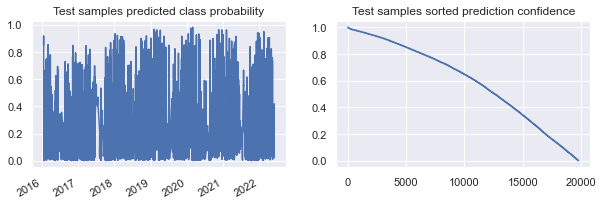

In [135]:
fig ,ax = plt.subplots(1, 2, figsize=(10, 3))
prob.plot(title='Test samples predicted class probability', ax=ax[0])
abs(1 - prob*2).reset_index(drop=True).plot(title='Test samples sorted prediction confidence', ax=ax[1])

### Score by confidence first

In [136]:
yhat = CP_filt.model.predict(xe)

steps = 500

cls_cnt, scrs = [], []
scr_cols = ['0', '1', 'macro avg']
thresholds = np.linspace(1/steps, 1, steps)
sample_sizes = (thresholds * len(xe)).astype('int')
for i, n_samples in enumerate(sample_sizes):
    co(wait=True); print(f'Samples: {i+1}/{steps} - threshold: {round(thresholds[i], 3)}')
    msk = ye.index.isin(prob.index[:n_samples])
    yi, yhati = ye[msk], yhat[msk]
    cls_cnt.append(yi.value_counts().rename(n_samples))
    scr = pd.DataFrame(cr(yi, yhati, output_dict=True))
    for col in scr_cols:
        if col not in scr:
            scr[col] = np.nan
    scr = scr.T.loc[scr_cols, ['precision', 'recall']]
    scr['n_samples'] = n_samples
    scr['confidence'] = abs(0.5 - prob.iloc[n_samples-1])
    scrs.append(scr)

scrs = pd.concat(scrs, 0)

Samples: 500/500 - threshold: 1.0


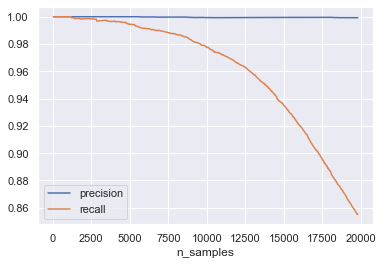

In [137]:
scrs.loc['0'].set_index('n_samples')[['precision', 'recall']].plot()
# abs(1 - prob*2).reset_index(drop=True).plot(title='Test samples sorted prediction confidence')

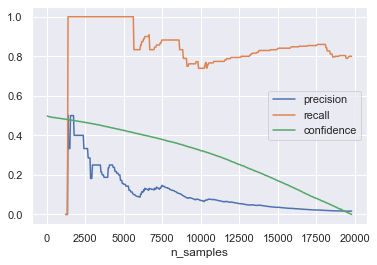

In [138]:
scrs.loc['1'].set_index('n_samples').plot()

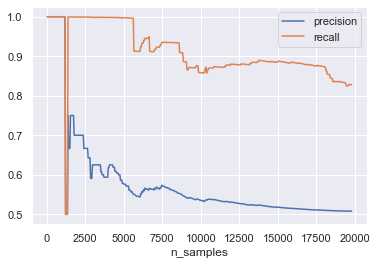

In [139]:
scrs.loc['macro avg'].set_index('n_samples')[['precision', 'recall']].plot()

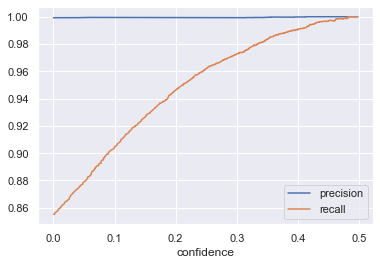

In [140]:
scrs.loc['0'].set_index('confidence')[['precision', 'recall']].plot()
# abs(1 - prob*2).reset_index(drop=True).plot(title='Test samples sorted prediction confidence')

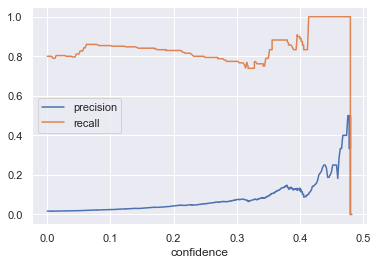

In [141]:
scrs.loc['1'].set_index('confidence')[['precision', 'recall']].plot()
# abs(1 - prob*2).reset_index(drop=True).plot(title='Test samples sorted prediction confidence')

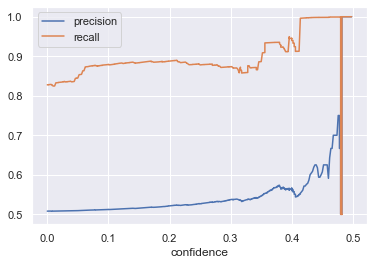

In [142]:
scrs.loc['macro avg'].set_index('confidence')[['precision', 'recall']].plot()

## Score by threshold

In [121]:
len(yhati)

19803

In [122]:
max_thresh = 1
scrs = []
for threshold in np.arange(.0, max_thresh, 0.01):
    co(wait=True); print(f'{threshold}/{max_thresh}')

    yhati = (prob.loc[ye.index] >= threshold).astype('float')
    scr = pd.DataFrame(cr(ye, yhati, output_dict=True))
    
    for col in scr_cols:
        if col not in scr:
            scr[col] = np.nan
    scr = scr.T.loc[scr_cols, ['precision', 'recall']]
    scr['threshold'] = threshold
    scrs.append(scr)

scrs = pd.concat(scrs, 0)

0.99/1


c:\Users\luisr\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\luisr\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\luisr\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


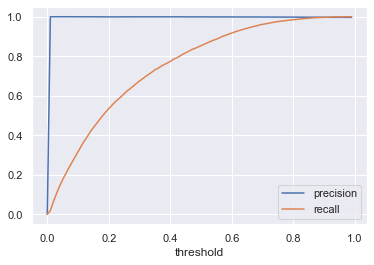

In [123]:
scrs.loc['0'].set_index('threshold').plot()
# abs(1 - prob*2).reset_index(drop=True).plot(title='Test samples sorted prediction confidence')

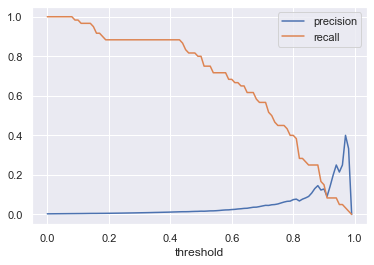

In [124]:
scrs.loc['1'].set_index('threshold').plot()

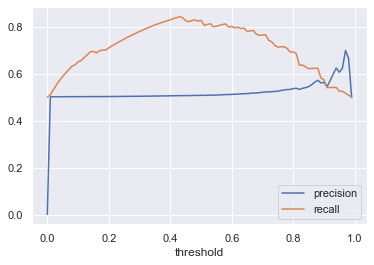

In [126]:
scrs.loc['macro avg'].set_index('threshold').plot()

---
# Critical water bag group - Exploratory Data analysis

In [192]:
bins = np.arange(0, 1.01, 0.01)
bins0 = np.arange(0, 1.01, 0.2)

### Minority variables percentiles

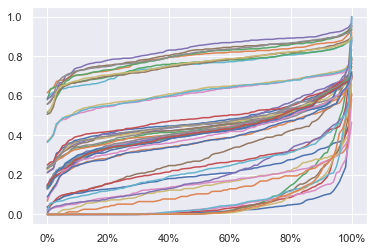

In [193]:
mino.iloc[:].describe(np.arange(0, 1.01, 0.01)).iloc[4:-1].plot(legend=[])

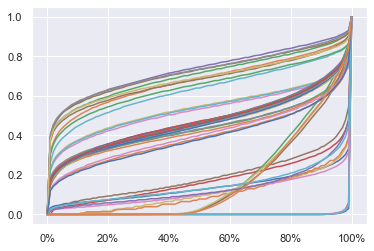

In [194]:
X.iloc[:].describe(np.arange(0, 1.01, 0.01)).iloc[4:-1].plot(legend=[])

## Average Difference

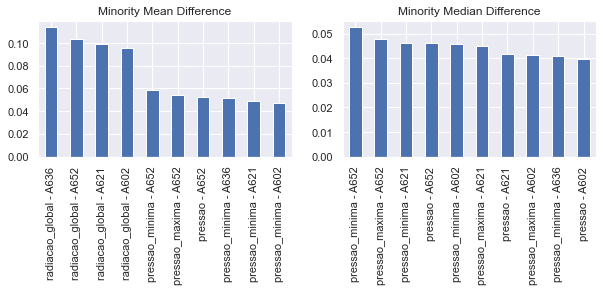

In [195]:
mean_diff = (majo.mean() - mino.mean()).sort_values(ascending=False)
median_diff = (majo.median() - mino.median()).sort_values(ascending=False)

fig, ax = plt.subplots(1, 2, figsize=(10,2.5))
mean_diff.head(10).plot.bar(ax=ax[0], title='Minority Mean Difference')
median_diff.head(10).plot.bar(ax=ax[1], title='Minority Median Difference')
plt.show()

## Incident/no-incident Distributions

#### Undersample majority class for plotting

In [ ]:
prct = np.percentile(Xf[Y==1].iloc[:, 0], range(101))
plt.plot(prct)
plt.show()
# plt.

,Class Count - Y
0,55628
1,296


,Class Count - Y Sample
1,296
0,296


KeyboardInterrupt: 

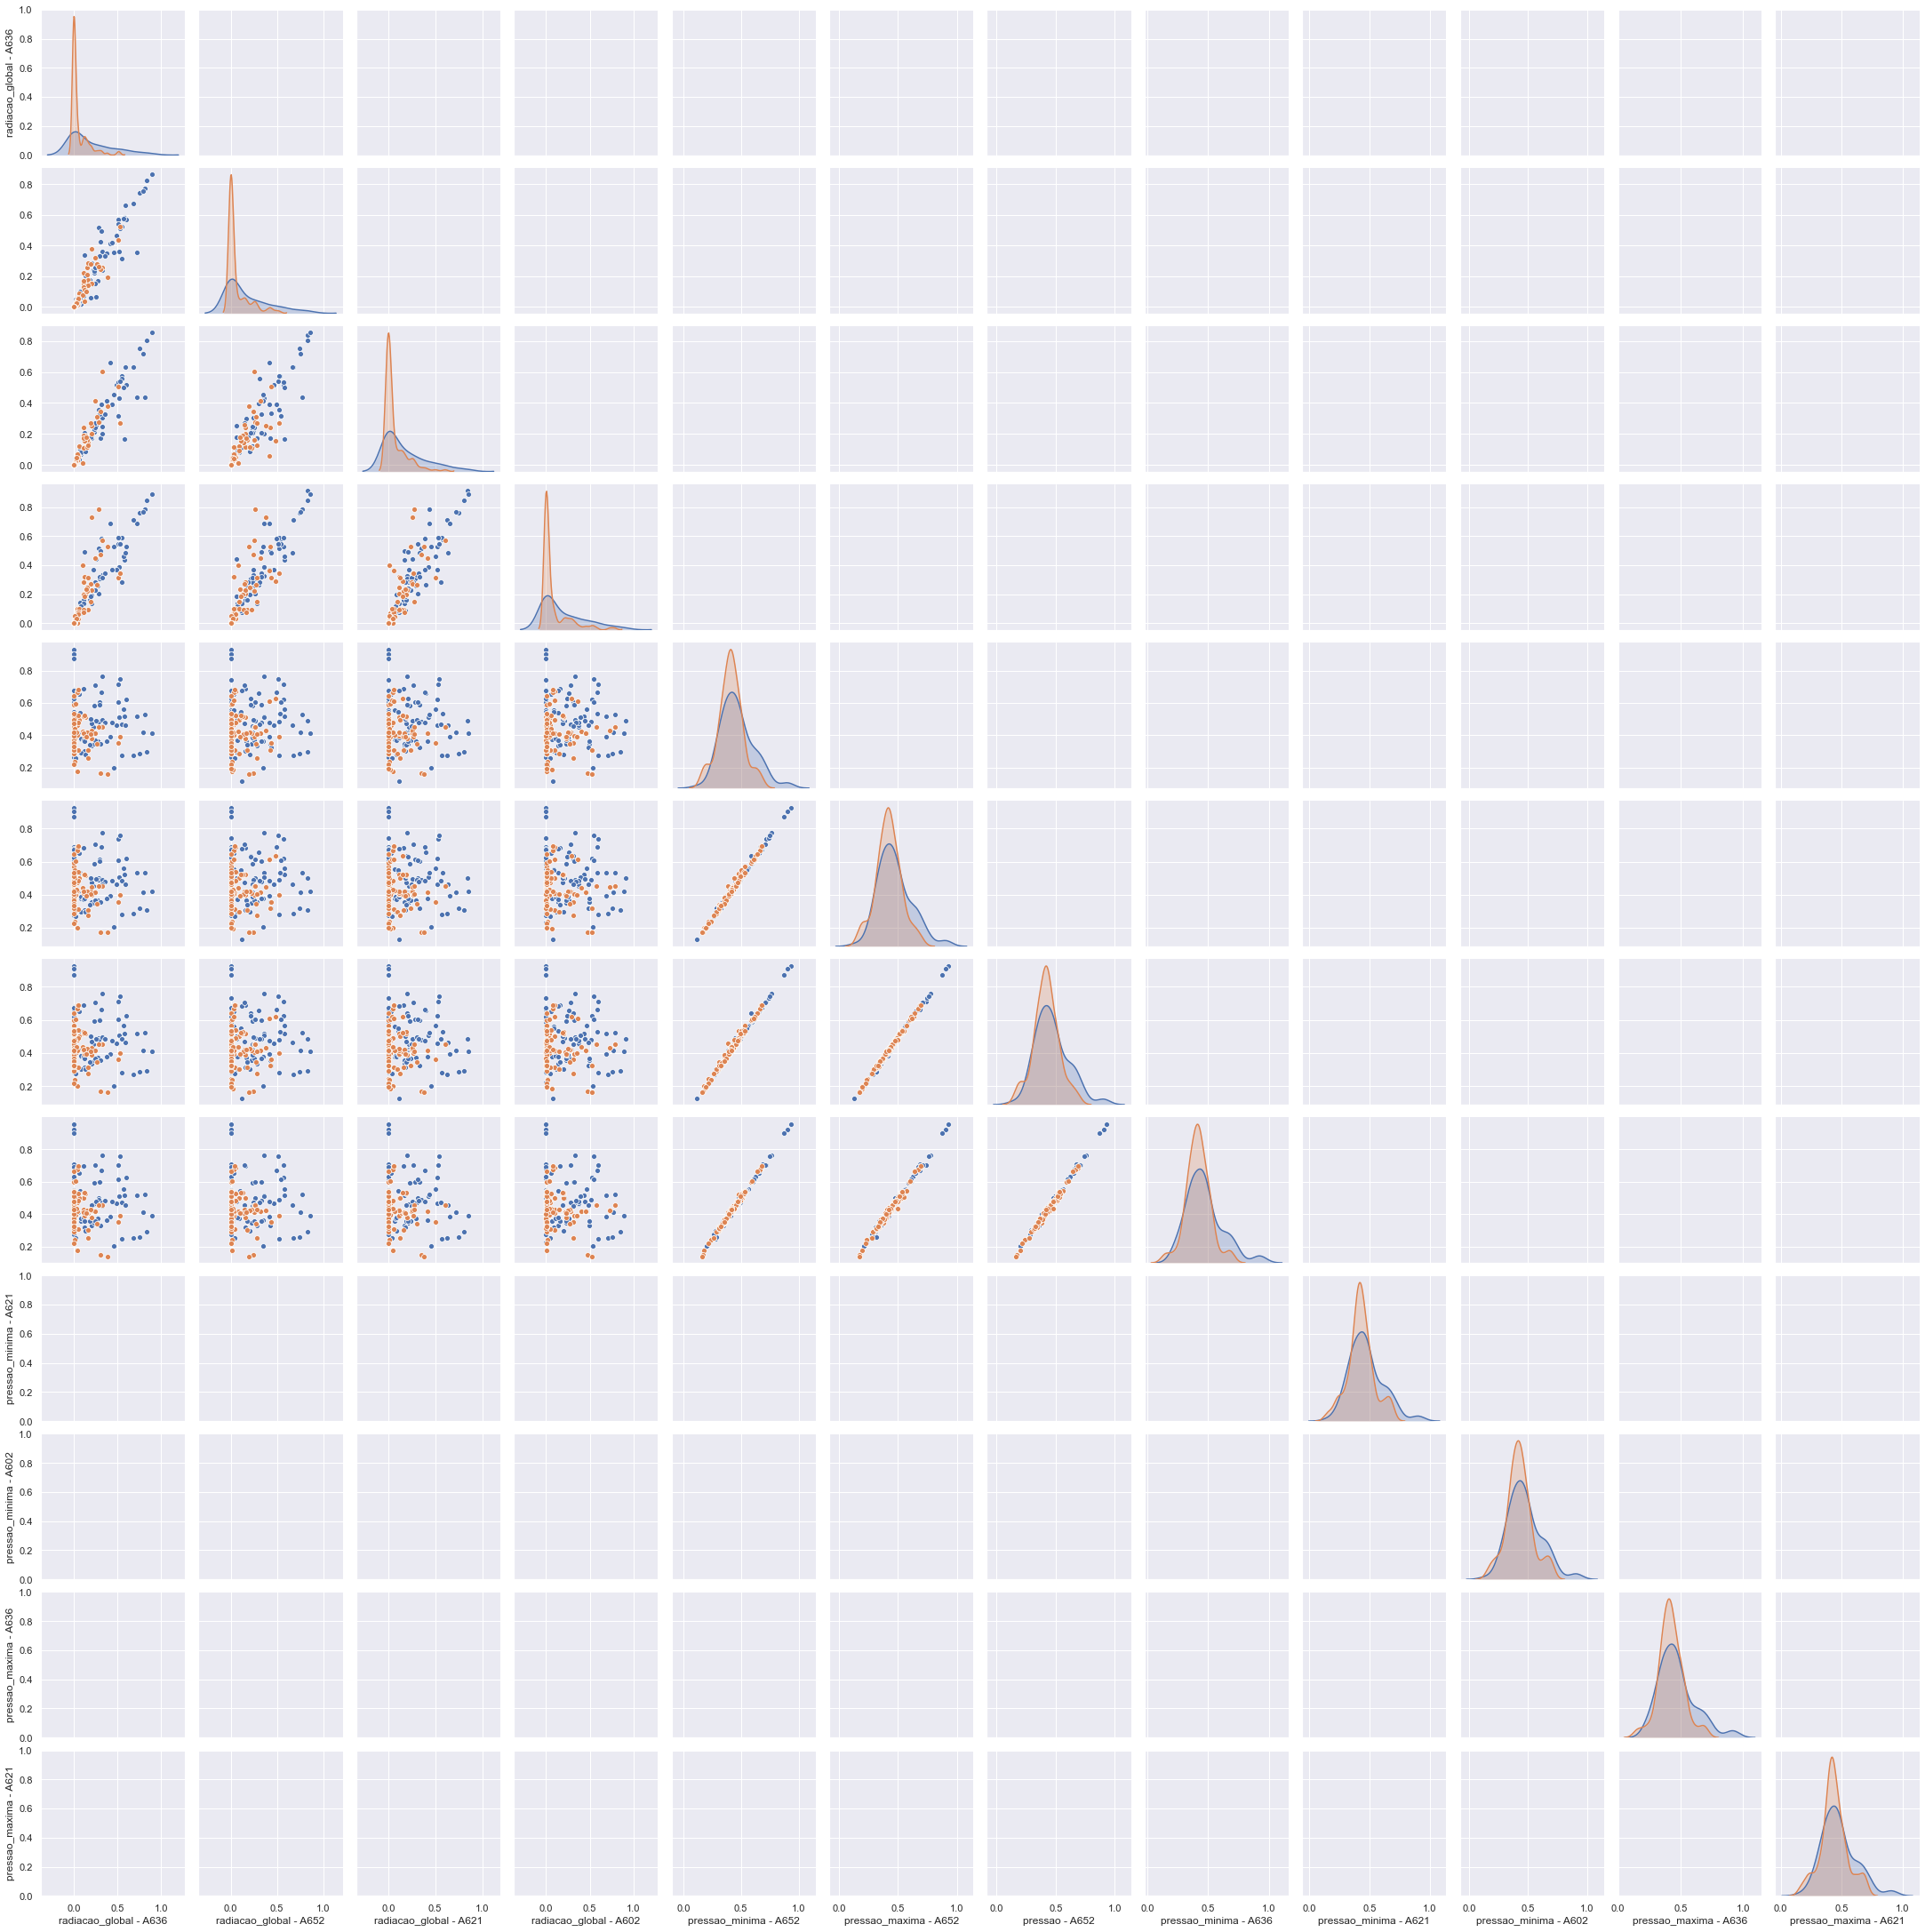

In [197]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy=1, random_state=42)

X_res, Y_res = rus.fit_resample(X, Y)
display(Y.value_counts().to_frame('Class Count - Y'))
display(Y_res.value_counts().to_frame('Class Count - Y Sample'))

ax = sns.pairplot(X_res[mean_diff.index[:12]].join(Y_res).sample(250), hue=top_grp, kind='scatter', diag_kind='auto')
plt.show()

,Class Count - Y
0,30087
1,548


,Class Count - Y Sample
1,548
0,548


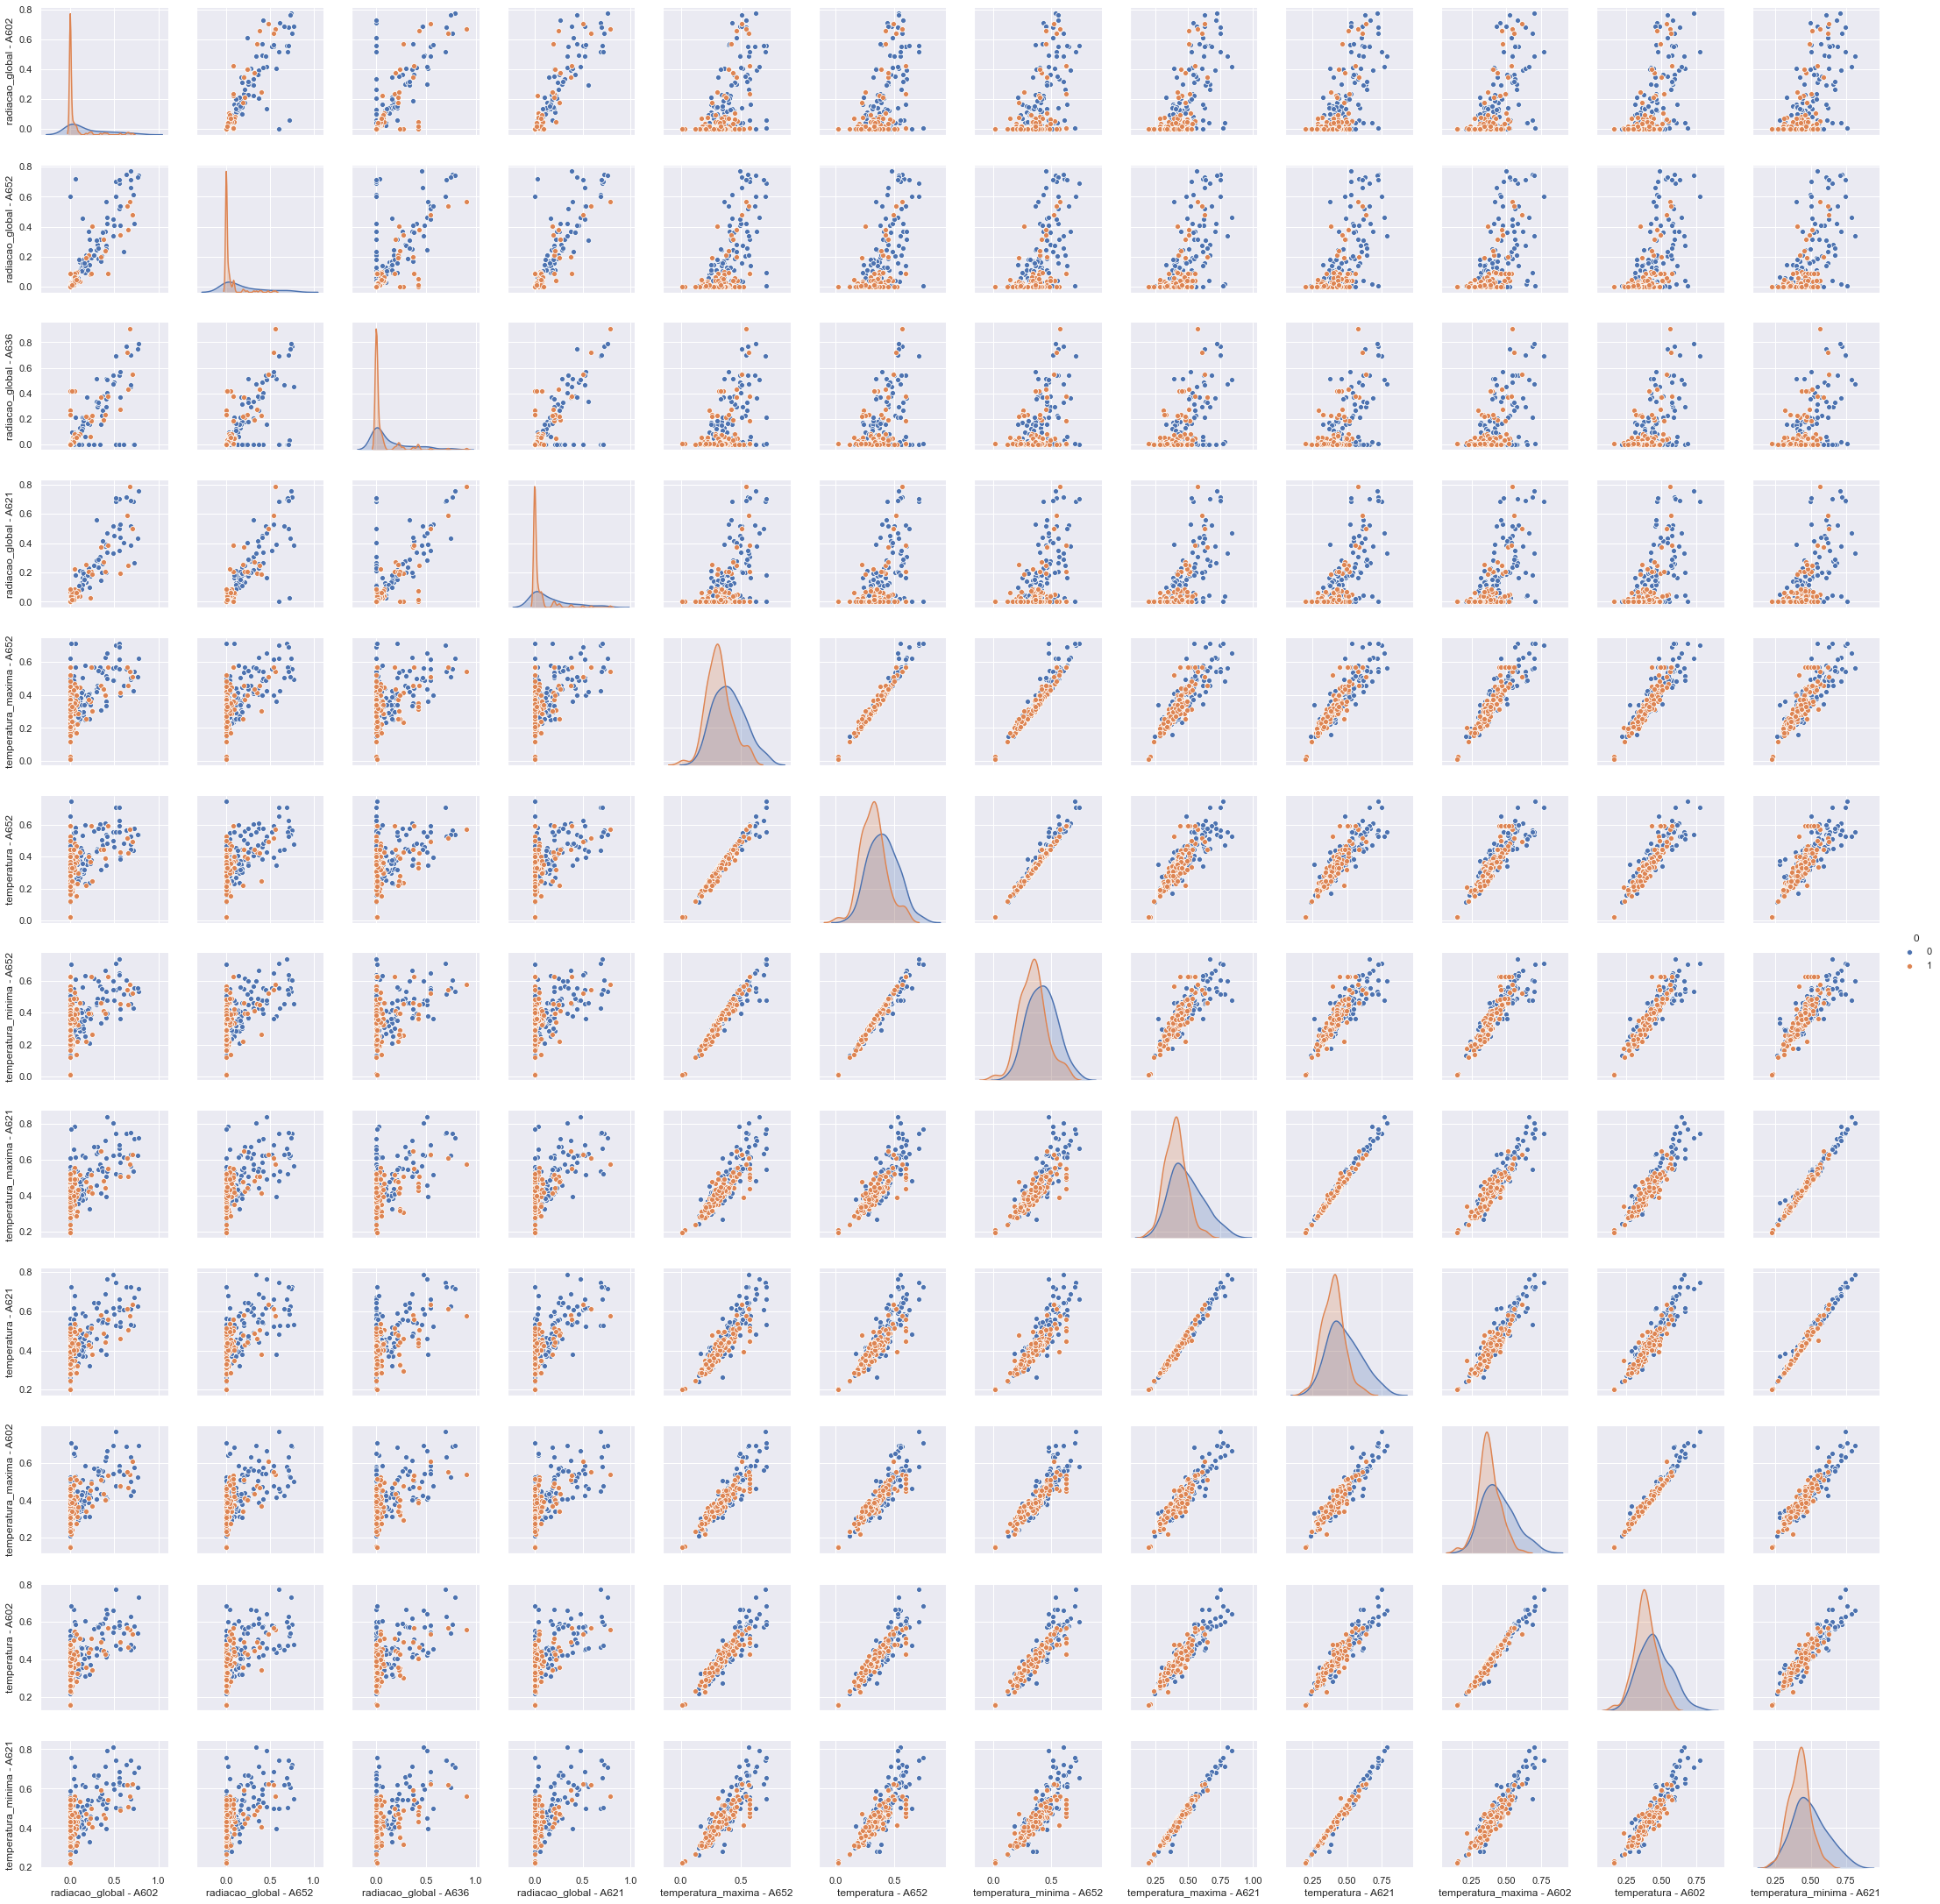

In [179]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy=1, random_state=42)

X_res, Y_res = rus.fit_resample(X_filt, Y_filt)
display(Y_filt.value_counts().to_frame('Class Count - Y'))
display(Y_res.value_counts().to_frame('Class Count - Y Sample'))

ax = sns.pairplot(X_res[mean_diff.index[:12]].join(Y_res).sample(250), hue=top_grp, kind='scatter', diag_kind='auto')
plt.show()